In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import itertools
from utils import *
import shap
pd.set_option("display.max_rows",100)

In [31]:
dataset_df = pd.read_csv(r"C:\Users\ghibl\ICR\data\input\all_features.csv")
dataset_df.drop("Id",axis = 1, inplace = True)

In [32]:
X_df = dataset_df.drop("Class",axis =1)
y_df = dataset_df["Class"].copy()


In [33]:
y_df.unique()

array([1, 0], dtype=int64)

In [34]:
dtrain = lgb.Dataset(X_df.values, label = y_df.values)
y_true = dtrain.get_label()
y_pred = np.array([0.5]*len(y_true))
balanced_logloss(y_pred,y_true)


0.6931471805599452

In [35]:
fs = X_df.columns
scores= []
evals_result = {}
skf = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 42)

for tr_idx, va_idx in skf.split(X_df, y_df):
    X_train, X_valid = X_df.iloc[tr_idx], X_df.iloc[va_idx]
    y_train, y_valid = y_df.iloc[tr_idx], y_df.iloc[va_idx]
    
    dtrain = lgb.Dataset(X_train.values, label = y_train.values)
    dvalid = lgb.Dataset(X_valid.values, label = y_valid.values)

    evals_result = {}
    params = {'metric':'custom',
              'objective':'binary',
              'verbosity':-1,
              'random_state' : 42, 
              'learning_rate': 0.1,
              'early_stopping_round':20
             }

    callbacks = [lgb.early_stopping(20, verbose=0), lgb.log_evaluation(period=10)]
    model = lgb.train(params,
                      dtrain, 
                      num_boost_round = 500,
                      valid_sets = [dtrain,dvalid],
                      valid_names = ['train','valid'],
                      feval = original_balanced_logloss_metric,
                      callbacks = callbacks
                     )
    score = model.best_score['valid']['balanced_logloss']
    scores.append(score)
    print(f'balanced_logloss:{score:.4f}')
score_cv = np.mean(scores)
print(score_cv)

[10]	train's balanced_logloss: 0.596008	valid's balanced_logloss: 0.631429
[20]	train's balanced_logloss: 0.549676	valid's balanced_logloss: 0.603006
[30]	train's balanced_logloss: 0.527021	valid's balanced_logloss: 0.592331
[40]	train's balanced_logloss: 0.515497	valid's balanced_logloss: 0.584424
[50]	train's balanced_logloss: 0.509649	valid's balanced_logloss: 0.579143
[60]	train's balanced_logloss: 0.506547	valid's balanced_logloss: 0.576285
[70]	train's balanced_logloss: 0.504955	valid's balanced_logloss: 0.573492
[80]	train's balanced_logloss: 0.504097	valid's balanced_logloss: 0.57078
[90]	train's balanced_logloss: 0.503661	valid's balanced_logloss: 0.569106
[100]	train's balanced_logloss: 0.503436	valid's balanced_logloss: 0.569319
balanced_logloss:0.5680
[10]	train's balanced_logloss: 0.597103	valid's balanced_logloss: 0.62296
[20]	train's balanced_logloss: 0.550506	valid's balanced_logloss: 0.599065
[30]	train's balanced_logloss: 0.527853	valid's balanced_logloss: 0.584692
[4

In [36]:
fs = X_df.columns
scores= []
evals_results = []
models = []
skf = StratifiedKFold(n_splits = 4, shuffle = True, random_state = 42)

for tr_idx, va_idx in skf.split(X_df, y_df):
    X_train, X_valid = X_df.iloc[tr_idx], X_df.iloc[va_idx]
    y_train, y_valid = y_df.iloc[tr_idx], y_df.iloc[va_idx]
    
    dtrain = lgb.Dataset(X_train, label = y_train)
    dvalid = lgb.Dataset(X_valid, label = y_valid)

    evals_result = {}
    params = {'metric':'custom',
              'objective':'custom',
              'verbosity':-1,
              'random_state' : 42, 
              'learning_rate': 0.1,
              'early_stopping_round':20
             }

    callbacks = [lgb.early_stopping(20, verbose=0), lgb.log_evaluation(period=10),lgb.record_evaluation(evals_result)]
    model = lgb.train(params,
                      dtrain, 
                      num_boost_round = 500,
                      valid_sets = [dtrain,dvalid],
                      valid_names = ['train','valid'],
                      feval = original_balanced_logloss_metric,
                      fobj = original_binary_logloss_objective,
                      callbacks = callbacks
                     )
    models.append(model)
    evals_results.append(evals_result)
    score = model.best_score['valid']['balanced_logloss']
    scores.append(score)
    print(f'balanced_logloss:{score:.4f}')
score_cv = np.mean(scores)
print(score_cv)

[10]	train's balanced_logloss: 0.35393	valid's balanced_logloss: 0.494908
[20]	train's balanced_logloss: 0.192145	valid's balanced_logloss: 0.383373
[30]	train's balanced_logloss: 0.106155	valid's balanced_logloss: 0.349127
[40]	train's balanced_logloss: 0.0558039	valid's balanced_logloss: 0.360636
[50]	train's balanced_logloss: 0.0297802	valid's balanced_logloss: 0.35916
balanced_logloss:0.3471
[10]	train's balanced_logloss: 0.340819	valid's balanced_logloss: 0.438081
[20]	train's balanced_logloss: 0.189033	valid's balanced_logloss: 0.383351
[30]	train's balanced_logloss: 0.106254	valid's balanced_logloss: 0.389613
[40]	train's balanced_logloss: 0.0586389	valid's balanced_logloss: 0.382897
[50]	train's balanced_logloss: 0.0312646	valid's balanced_logloss: 0.367835
[60]	train's balanced_logloss: 0.0165526	valid's balanced_logloss: 0.388008
[70]	train's balanced_logloss: 0.00875119	valid's balanced_logloss: 0.413369
balanced_logloss:0.3678
[10]	train's balanced_logloss: 0.337247	valid's

# 0.38349947449517713

In [37]:
fig = make_subplots(rows = 2,cols = 2,
                    subplot_titles=("fold1", "fold2", "fold3", "fold4"))
tuples = [(1,1),(1,2),(2,1),(2,2)]
for i in range(len(evals_results)):
    train_log = evals_results[i]['train']['balanced_logloss'] 
    eval_log = evals_results[i]['valid']['balanced_logloss'] 
    x = np.arange(1,1+len(train_log))
    fig.add_trace(go.Scatter(x = x, y = train_log,mode = 'lines',name = 'train'),
                 row = tuples[i][0],col = tuples[i][1])
    fig.add_trace(go.Scatter(x = x, y = eval_log,mode = 'lines',name = 'eval'),
                 row = tuples[i][0],col = tuples[i][1])
fig.update_layout(
    title = "fold1, fold2, fold3, fold4"
)

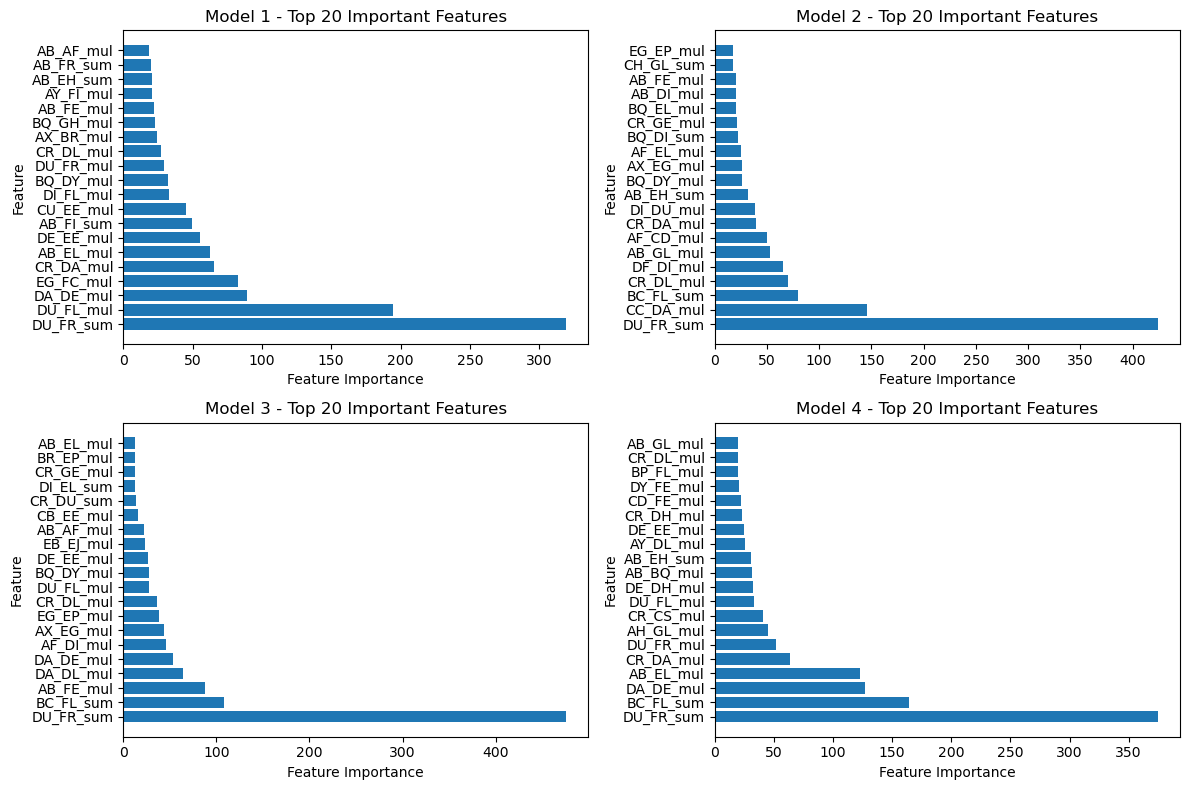

In [38]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))


# 各モデルに対して特徴量の重要度をプロット
for i, model in enumerate(models):
    # 重要度の取得
    importance = model.feature_importance(importance_type='gain')
    # 特徴量の名前の取得
    feature_names = model.feature_name()

    # 重要度を降順にソートして上位20個を選択
    top_features = sorted(zip(feature_names, importance), key=lambda x: x[1], reverse=True)[:20]
    # 上位20個の特徴量とその重要度を取得
    top_feature_names = [feat[0] for feat in top_features]
    top_feature_importance = [feat[1] for feat in top_features]

    # サブプロットにプロット
    ax = axes[i // 2, i % 2]  # サブプロットの位置を指定
    ax.barh(range(len(top_feature_names)), top_feature_importance, align='center')
    ax.set_yticks(range(len(top_feature_names)))
    ax.set_yticklabels(top_feature_names)
    ax.set_xlabel('Feature Importance')
    ax.set_ylabel('Feature')
    ax.set_title(f'Model {i+1} - Top 20 Important Features')

# サブプロット間のスペースを調整
plt.tight_layout()

# プロットの表示
plt.show()

In [49]:
evaluate(X_df.columns,X_df,y_df)

0.38747571516830626

In [40]:
len(model.feature_importance())

3151

In [58]:
feature_importances = []
feature_names = []
features_df = pd.DataFrame()
for i,model in enumerate(models):
    feature_importance = model.feature_importance(importance_type='gain')
    feature_importances.append(feature_importance)
    features_df[f"Fold{i+1}"] = feature_importance
feature_name = model.feature_name()
feature_importances_array = np.array(feature_importances)
mean_importances = np.mean(feature_importances,axis = 0)
std_importances = np.std(feature_importances,axis = 0)
coefficient_of_variation = std_importances / mean_importances

features_df["Mean"] = mean_importances
features_df["Std"] = std_importances
features_df["CV"] = coefficient_of_variation
features_df.set_axis(feature_name,axis = 0, inplace = True)


C:\Users\ghibl\AppData\Local\Temp\ipykernel_5256\3122687559.py:12: RuntimeWarning:

invalid value encountered in divide

C:\Users\ghibl\AppData\Local\Temp\ipykernel_5256\3122687559.py:17: FutureWarning:

DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead



In [59]:
features_df["CV"].notnull().sum()

1258

In [60]:
features_df_nonull = features_df.dropna(how = "any")

In [61]:
features_df_nonull.sort_values(by ="CV", ascending = True).head(30)

,Fold1,Fold2,Fold3,Fold4,Mean,Std,CV
DU_FR_sum,319.412841,424.188562,475.663838,374.608086,398.468332,57.964986,0.145469
BQ_DY_mul,32.499933,26.327416,27.277645,9.524480,23.907368,8.630108,0.360981
AB_AF_mul,18.800375,5.737046,22.489401,15.898708,15.731383,6.225036,0.395708
CR_DL_mul,27.487558,70.449392,36.422439,19.782883,38.535568,19.343469,0.501964
BC_FL_sum,17.887690,79.782726,108.735059,164.297642,92.675779,52.789868,0.569619
BQ_GH_mul,23.119096,17.166317,0.037055,17.458830,14.445324,8.650398,0.598837
AB_EH_sum,20.614034,32.100254,0.000000,30.964391,20.919670,12.880488,0.615712
AY_DL_mul,7.505700,10.794710,5.913060,25.338216,12.387921,7.681282,0.620062
CR_DA_mul,65.499368,39.821721,0.000000,63.617491,42.234645,26.401046,0.625104
CD_GL_mul,10.165900,17.339835,0.000000,15.273488,10.694806,6.704091,0.626855


In [45]:
selected = list(features_df_nonull.index)
len(selected)

1258

In [50]:
evaluate(selected,X_df,y_df)

0.38612527880939673